# Modelos de Linguagem com LSTM

Este notebook introduz os **Modelos de Linguagem** (*Language Models*), uma das aplicações mais fundamentais e poderosas do processamento de linguagem natural. Exploraremos a teoria matemática por trás desses modelos e implementaremos uma versão prática usando **Long Short-Term Memory (LSTM)** networks com PyTorch.

## Conteúdos Abordados

1. **Fundamentos Teóricos de Modelos de Linguagem**: A matemática da modelagem probabilística da linguagem
2. **Long Short-Term Memory (LSTM)**: Arquitetura avançada para sequências longas
3. **Implementação de um Modelo de Linguagem com LSTM**: Construção completa do pipeline
4. **Geração Autorregressiva**: Como gerar texto de forma probabilística
5. **Análise de Perplexidade**: Métrica de avaliação de modelos de linguagem
6. **Análise dos Embeddings Aprendidos**: Visualização do espaço semântico

## 1. Fundamentos Teóricos de Modelos de Linguagem

Um **modelo de linguagem** é um modelo probabilístico que atribui probabilidades a sequências de palavras. Formalmente, dado um vocabulário $V$ e uma sequência de palavras $w_1, w_2, \ldots, w_T$, um modelo de linguagem estima a probabilidade conjunta:

$$P(w_1, w_2, \ldots, w_T)$$

### Decomposição Autorregressiva

Pela regra da cadeia da probabilidade, podemos decompor essa probabilidade conjunta como:

$$P(w_1, w_2, \ldots, w_T) = \prod_{t=1}^{T} P(w_t | w_1, w_2, \ldots, w_{t-1})$$

Onde $P(w_t | w_1, \ldots, w_{t-1})$ é a **probabilidade condicional** da palavra $w_t$ dado todo o contexto anterior. Esta decomposição é chamada de **autorregressiva** porque cada palavra é modelada condicionalmente em relação às palavras anteriores.

### O Problema da Maldição da Dimensionalidade

Estimar $P(w_t | w_1, \ldots, w_{t-1})$ diretamente é impraticável, pois:
1. O número de possíveis contextos cresce exponencialmente com o comprimento
2. A maioria das sequências específicas nunca aparece nos dados de treino

### Aproximação Neural

Modelos neurais de linguagem resolvem este problema aprendendo uma função paramétrica $f_\theta$:

$$P(w_t | w_1, \ldots, w_{t-1}) \approx f_\theta(w_1, \ldots, w_{t-1})$$

Onde $\theta$ representa os parâmetros da rede neural (pesos e biases).

## 2. Long Short-Term Memory (LSTM)

Enquanto RNNs tradicionais sofrem do problema de **desvanecimento do gradiente** (*vanishing gradient*), as **LSTMs** foram projetadas especificamente para capturar dependências de longo prazo em sequências.

### Arquitetura da Célula LSTM

Uma célula LSTM possui três **gates** (portões) que controlam o fluxo de informação:

1. **Forget Gate** ($f_t$): Decide quanta informação descartar do estado da célula
2. **Input Gate** ($i_t$): Decide quais valores atualizar no estado da célula
3. **Output Gate** ($o_t$): Controla quais partes do estado da célula serão outputadas

### Equações Matemáticas da LSTM

Para o tempo $t$, com entrada $x_t$ e estado oculto anterior $h_{t-1}$:

**Gates:**
$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$

**Candidato a novo estado:**
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

**Estado da célula:**
$$C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$$

**Estado oculto:**
$$h_t = o_t * \tanh(C_t)$$

Onde $\sigma$ é a função sigmoid, $*$ denota multiplicação elemento-a-elemento, e $W$, $b$ são as matrizes de pesos e vetores de bias, respectivamente.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import re
from collections import Counter
import math

## 3. Preparação dos Dados

Para treinar nosso modelo de linguagem, utilizaremos um corpus de texto em português. O processo de preparação envolve:

1. **Limpeza e tokenização** do texto
2. **Construção do vocabulário** com as palavras mais frequentes
3. **Criação de sequências** de treinamento com janela deslizante
4. **Mapeamento** de tokens para índices numéricos

In [2]:
# Corpus expandido em português sobre inteligência artificial
corpus_text = """
A inteligencia artificial e uma area da ciencia da computacao que se concentra no desenvolvimento de sistemas capazes de realizar tarefas que normalmente requerem inteligencia humana.
O aprendizado de maquina e um subcampo da inteligencia artificial que permite aos computadores aprender e melhorar automaticamente atraves da experiencia.
As redes neurais artificiais sao inspiradas no funcionamento do cerebro humano e consistem em nos interconectados que processam informacoes.
O aprendizado profundo utiliza redes neurais com multiplas camadas para modelar e compreender dados complexos.
Os algoritmos de aprendizado supervisionado aprendem a partir de exemplos rotulados para fazer predicoes sobre novos dados.
O aprendizado nao supervisionado descobre padroes ocultos em dados sem rotulos explicitos.
O processamento de linguagem natural permite que os computadores compreendam e gerem texto em linguagem humana.
A visao computacional capacita as maquinas a interpretar e analisar conteudo visual do mundo real.
Os sistemas de recomendacao utilizam algoritmos de aprendizado de maquina para sugerir produtos ou conteudo aos usuarios.
A robotica integra inteligencia artificial com engenharia mecanica para criar maquinas autonomas.
O reconhecimento de padroes e fundamental para identificar estruturas e regularidades nos dados.
Os modelos generativos podem criar novos dados que se assemelham aos dados de treinamento originais.
A otimizacao e crucial para encontrar os melhores parametros em algoritmos de aprendizado de maquina.
O overfitting ocorre quando um modelo aprende muito especificamente os dados de treino perdendo capacidade de generalizacao.
A validacao cruzada e uma tecnica para avaliar o desempenho de modelos de forma mais robusta.
As funcoes de ativacao introduzem nao linearidade nas redes neurais permitindo modelar relacoes complexas.
O gradiente descendente e um algoritmo de otimizacao usado para treinar modelos de aprendizado de maquina.
A regularizacao ajuda a prevenir o overfitting adicionando penalidades aos parametros do modelo.
Os transformadores revolucionaram o processamento de linguagem natural com mecanismos de atencao.
A inteligencia artificial generativa pode criar texto imagens audio e outros tipos de conteudo criativo.
"""

print(f"Tamanho do corpus: {len(corpus_text)} caracteres")
print(f"Primeiros 200 caracteres:")
print(corpus_text[:200])

Tamanho do corpus: 2271 caracteres
Primeiros 200 caracteres:

A inteligencia artificial e uma area da ciencia da computacao que se concentra no desenvolvimento de sistemas capazes de realizar tarefas que normalmente requerem inteligencia humana.
O aprendizado d


In [3]:
def preprocess_text(text):
    """Limpa e tokeniza o texto."""
    # Converter para minúsculas e remover caracteres especiais
    text = text.lower()
    text = re.sub(r'[^a-záàâãéèêíìîóòôõúùûç\s]', '', text)

    # Tokenizar por palavras
    tokens = text.split()

    return tokens

def build_vocabulary(tokens, vocab_size=1000):
    """Constrói vocabulário com as palavras mais frequentes."""
    counter = Counter(tokens)

    # Tokens especiais
    special_tokens = ['<UNK>', '<START>', '<END>']

    # Palavras mais frequentes (excluindo tokens especiais)
    frequent_words = [word for word, _ in counter.most_common(vocab_size - len(special_tokens))]

    # Vocabulário completo
    vocabulary = special_tokens + frequent_words

    # Mapeamentos
    word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}

    return vocabulary, word_to_idx, idx_to_word

# Processar o corpus
tokens = preprocess_text(corpus_text)
vocabulary, word_to_idx, idx_to_word = build_vocabulary(tokens, vocab_size=200)

print(f"Total de tokens: {len(tokens)}")
print(f"Vocabulário único: {len(vocabulary)}")
print(f"Primeiras 20 palavras do vocabulário: {vocabulary[:20]}")

Total de tokens: 316
Vocabulário único: 174
Primeiras 20 palavras do vocabulário: ['<UNK>', '<START>', '<END>', 'de', 'e', 'a', 'o', 'para', 'aprendizado', 'dados', 'os', 'que', 'inteligencia', 'artificial', 'da', 'maquina', 'aos', 'em', 'um', 'as']


In [4]:
def encode_tokens(tokens, word_to_idx):
    """Converte tokens em índices numéricos."""
    unk_idx = word_to_idx['<UNK>']
    return [word_to_idx.get(token, unk_idx) for token in tokens]

def create_training_sequences(encoded_tokens, seq_length):
    """Cria sequências de entrada e alvos para treinamento."""
    sequences = []
    targets = []

    for i in range(len(encoded_tokens) - seq_length):
        seq = encoded_tokens[i:i + seq_length]
        target = encoded_tokens[i + seq_length]
        sequences.append(seq)
        targets.append(target)

    return sequences, targets

# Codificar tokens
encoded_tokens = encode_tokens(tokens, word_to_idx)

# Criar sequências de treinamento
seq_length = 10  # Comprimento da sequência de contexto
sequences, targets = create_training_sequences(encoded_tokens, seq_length)

print(f"Número total de sequências de treinamento: {len(sequences)}")
print(f"Exemplo de sequência: {sequences[0]}")
print(f"Alvo correspondente: {targets[0]}")

# Decodificar para verificar
example_seq_words = [idx_to_word[idx] for idx in sequences[0]]
example_target_word = idx_to_word[targets[0]]
print(f"Sequência em palavras: {example_seq_words}")
print(f"Alvo em palavra: {example_target_word}")

Número total de sequências de treinamento: 306
Exemplo de sequência: [5, 12, 13, 4, 29, 50, 14, 51, 14, 52]
Alvo correspondente: 11
Sequência em palavras: ['a', 'inteligencia', 'artificial', 'e', 'uma', 'area', 'da', 'ciencia', 'da', 'computacao']
Alvo em palavra: que


## 4. Dataset Personalizado para PyTorch

Criaremos uma classe Dataset personalizada para facilitar o carregamento dos dados em lotes (*batches*) durante o treinamento.

In [5]:
class LanguageModelDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return (
            torch.LongTensor(self.sequences[idx]),
            torch.LongTensor([self.targets[idx]])
        )

# Criar dataset e dataloader
dataset = LanguageModelDataset(sequences, targets)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Dataset criado com {len(dataset)} exemplos")
print(f"Número de lotes: {len(dataloader)}")

# Testar um lote
for batch_seq, batch_target in dataloader:
    print(f"Formato do lote de sequências: {batch_seq.shape}")
    print(f"Formato do lote de alvos: {batch_target.shape}")
    break

Dataset criado com 306 exemplos
Número de lotes: 10
Formato do lote de sequências: torch.Size([32, 10])
Formato do lote de alvos: torch.Size([32, 1])


## 5. Implementação do Modelo de Linguagem com LSTM

Nossa arquitetura consistirá em:

1. **Camada de Embedding**: Converte índices de palavras em vetores densos
2. **Camada LSTM**: Processa a sequência e mantém memória de longo prazo
3. **Camada Linear de Saída**: Projeta do espaço oculto para o vocabulário
4. **Dropout**: Regularização para prevenir overfitting

A saída final são **logits** sobre todo o vocabulário, que são convertidos em probabilidades via **softmax**.

In [6]:
class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=2, dropout=0.3):
        super(LSTMLanguageModel, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.vocab_size = vocab_size

        # Camadas da rede
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        """
        Forward pass do modelo.

        Args:
            x: tensor de entrada [batch_size, seq_length]
            hidden: estado oculto inicial (opcional)

        Returns:
            output: logits sobre vocabulário [batch_size, seq_length, vocab_size]
            hidden: estado oculto final
        """
        batch_size = x.size(0)

        # Embedding: [batch_size, seq_length] -> [batch_size, seq_length, embedding_dim]
        embedded = self.embedding(x)

        # LSTM: [batch_size, seq_length, embedding_dim] -> [batch_size, seq_length, hidden_dim]
        lstm_out, hidden = self.lstm(embedded, hidden)

        # Dropout para regularização
        lstm_out = self.dropout(lstm_out)

        # Projeção para vocabulário: [batch_size, seq_length, hidden_dim] -> [batch_size, seq_length, vocab_size]
        output = self.fc_out(lstm_out)

        return output, hidden

    def init_hidden(self, batch_size, device):
        """Inicializa estado oculto com zeros."""
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device))

# Hiperparâmetros do modelo
vocab_size = len(vocabulary)
embedding_dim = 64
hidden_dim = 128
num_layers = 2
dropout = 0.3

# Instanciar modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMLanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout)
model = model.to(device)

print(f"Modelo criado com {sum(p.numel() for p in model.parameters())} parâmetros")
print(f"Dispositivo: {device}")
print(model)

Modelo criado com 265006 parâmetros
Dispositivo: cpu
LSTMLanguageModel(
  (embedding): Embedding(174, 64)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc_out): Linear(in_features=128, out_features=174, bias=True)
)


## 6. Treinamento do Modelo

O treinamento de um modelo de linguagem usa **Cross-Entropy Loss** entre as probabilidades preditas e as palavras reais. A cada época, passamos todas as sequências pelo modelo e atualizamos os parâmetros via **backpropagation**.

### Função de Loss

Para uma sequência de entrada $x_1, \ldots, x_T$ e alvo $y$, a loss é:

$$\mathcal{L} = -\log P(y | x_1, \ldots, x_T) = -\log \frac{\exp(\text{logit}_y)}{\sum_{i=1}^{|V|} \exp(\text{logit}_i)}$$

In [7]:
# Configuração de treinamento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

# Lista para armazenar perdas
training_losses = []

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Treina o modelo por uma época."""
    model.train()
    total_loss = 0.0
    num_batches = 0

    for batch_seq, batch_target in dataloader:
        batch_seq = batch_seq.to(device)
        batch_target = batch_target.squeeze(-1).to(device)  # Remove dimensão extra

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output, _ = model(batch_seq)

        # Pegar apenas o último token de saída para cada sequência
        # output shape: [batch_size, seq_length, vocab_size]
        # Queremos: [batch_size, vocab_size]
        last_output = output[:, -1, :]

        # Calcular loss
        loss = criterion(last_output, batch_target)

        # Backward pass
        loss.backward()

        # Gradient clipping (importante para LSTMs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Atualizar parâmetros
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches

print("Iniciando treinamento...")

for epoch in tqdm(range(num_epochs)):
    epoch_loss = train_epoch(model, dataloader, criterion, optimizer, device)
    training_losses.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Época [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Treinamento concluído!")

Iniciando treinamento...


  0%|          | 0/50 [00:00<?, ?it/s]

Época [10/50], Loss: 3.9571
Época [20/50], Loss: 2.3717
Época [30/50], Loss: 1.5427
Época [40/50], Loss: 1.0061
Época [50/50], Loss: 0.6144
Treinamento concluído!


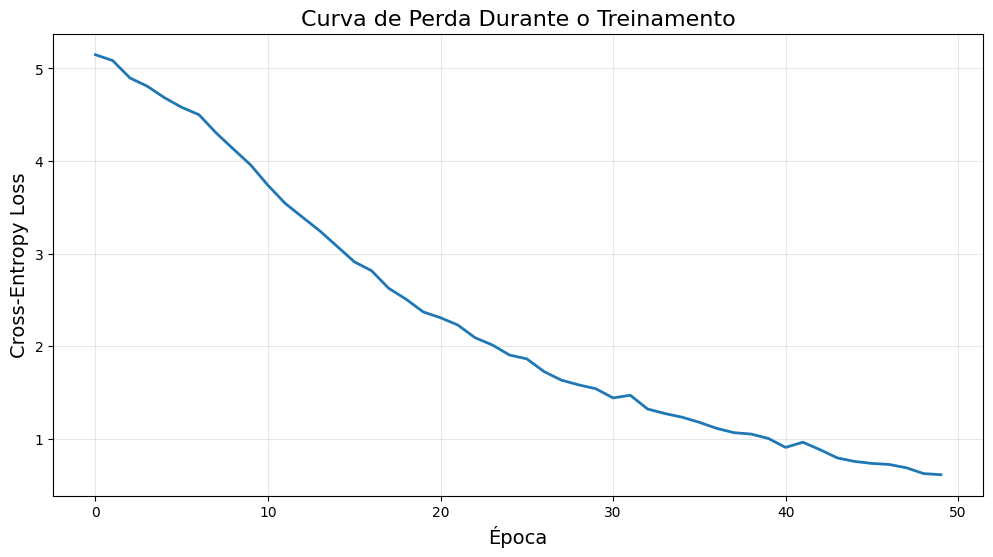

Perda inicial: 5.1476
Perda final: 0.6144
Redução: 88.1%


In [8]:
# Visualizar curva de perda
plt.figure(figsize=(12, 6))
plt.plot(training_losses, linewidth=2)
plt.title('Curva de Perda Durante o Treinamento', fontsize=16)
plt.xlabel('Época', fontsize=14)
plt.ylabel('Cross-Entropy Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Perda inicial: {training_losses[0]:.4f}")
print(f"Perda final: {training_losses[-1]:.4f}")
print(f"Redução: {((training_losses[0] - training_losses[-1]) / training_losses[0] * 100):.1f}%")

## 7. Geração Autorregressiva de Texto

Agora implementaremos a **geração autorregressiva**, onde o modelo gera texto palavra por palavra, usando suas próprias predições anteriores como entrada para as próximas predições.

### Processo de Geração

1. Começamos com uma sequência *seed* (semente)
2. O modelo prediz a próxima palavra mais provável
3. Adicionamos essa palavra à sequência
4. Repetimos o processo usando a nova sequência como entrada

### Estratégias de Amostragem

- **Greedy**: Sempre escolher a palavra mais provável
- **Random Sampling**: Amostrar aleatoriamente da distribuição de probabilidade
- **Temperature Sampling**: Controlar a "criatividade" com um parâmetro de temperatura

In [9]:
def generate_text(model, seed_text, max_length=50, temperature=1.0, device='cpu'):
    """
    Gera texto usando o modelo treinado.

    Args:
        model: modelo LSTM treinado
        seed_text: texto inicial (string)
        max_length: número máximo de palavras a gerar
        temperature: controla aleatoriedade (1.0 = normal, >1.0 = mais criativo, <1.0 = mais conservador)
        device: dispositivo (cpu ou cuda)

    Returns:
        texto gerado (string)
    """
    model.eval()

    # Tokenizar e codificar texto seed
    seed_tokens = preprocess_text(seed_text)
    if len(seed_tokens) == 0:
        seed_tokens = ['inteligencia']  # Fallback

    # Codificar tokens
    seed_indices = encode_tokens(seed_tokens, word_to_idx)

    # Garantir que temos pelo menos seq_length tokens
    if len(seed_indices) < seq_length:
        # Pad com tokens <START>
        start_idx = word_to_idx['<START>']
        seed_indices = [start_idx] * (seq_length - len(seed_indices)) + seed_indices
    else:
        # Usar apenas os últimos seq_length tokens
        seed_indices = seed_indices[-seq_length:]

    generated_indices = seed_indices.copy()
    current_sequence = seed_indices.copy()

    with torch.no_grad():
        for _ in range(max_length):
            # Converter para tensor
            input_tensor = torch.LongTensor([current_sequence]).to(device)

            # Forward pass
            output, _ = model(input_tensor)

            # Pegar logits da última posição
            last_logits = output[0, -1, :]

            # Aplicar temperature
            if temperature != 1.0:
                last_logits = last_logits / temperature

            # Converter para probabilidades
            probabilities = F.softmax(last_logits, dim=0)

            # Amostrar próxima palavra
            if temperature == 0.0:  # Greedy
                next_token_idx = torch.argmax(probabilities).item()
            else:  # Sampling
                next_token_idx = torch.multinomial(probabilities, 1).item()

            # Parar se gerar token de fim
            if next_token_idx == word_to_idx.get('<END>', -1):
                break

            # Adicionar nova palavra
            generated_indices.append(next_token_idx)

            # Atualizar sequência atual (janela deslizante)
            current_sequence = current_sequence[1:] + [next_token_idx]

    # Decodificar de volta para texto
    generated_words = []
    for idx in generated_indices:
        word = idx_to_word.get(idx, '<UNK>')
        if word not in ['<START>', '<END>', '<UNK>']:
            generated_words.append(word)

    return ' '.join(generated_words)

# Testar geração com diferentes seeds e temperaturas
seeds = [
    "inteligencia artificial",
    "aprendizado de maquina",
    "redes neurais"
]

temperatures = [0.5, 1.0, 1.5]

print("=== EXEMPLOS DE GERAÇÃO DE TEXTO ===")
print()

for seed in seeds:
    print(f"Seed: '{seed}'")
    print("-" * 50)

    for temp in temperatures:
        generated_text = generate_text(model, seed, max_length=30, temperature=temp, device=device)
        print(f"Temperature {temp}: {generated_text}")

    print()


=== EXEMPLOS DE GERAÇÃO DE TEXTO ===

Seed: 'inteligencia artificial'
--------------------------------------------------
Temperature 0.5: inteligencia artificial dados dados dados dados dados sem ocultos criar atraves conteudo ativacao dados dados de de linguagem aos neurais inspiradas maquinas para a a overfitting o e conteudo nos os para
Temperature 1.0: inteligencia artificial dados dados os dados dados sem modelar visao em de assemelham com aprende e o maquina quando inteligencia modelo que gradiente dados natural dados e computadores e em em supervisionado
Temperature 1.5: inteligencia artificial dados maquinas os dados algoritmos de em padroes e de atraves usuarios estruturas e pode aprendizado a requerem que sem computadores inspiradas texto mundo modelo e descendente e regularidades funcionamento

Seed: 'aprendizado de maquina'
--------------------------------------------------
Temperature 0.5: aprendizado de maquina dados de que inteligencia inteligencia a maquinas maquinas in

## 8. Avaliação: Perplexidade do Modelo

A **perplexidade** é a métrica padrão para avaliar modelos de linguagem. Ela mede quão "surpreso" o modelo fica com uma sequência de palavras. Matematicamente:

$$\text{Perplexidade} = \exp\left(-\frac{1}{T} \sum_{t=1}^{T} \log P(w_t | w_1, \ldots, w_{t-1})\right)$$

- **Perplexidade menor** = modelo melhor
- **Perplexidade = tamanho do vocabulário** = modelo aleatório
- **Perplexidade = 1** = modelo perfeito (impossível na prática)

In [10]:
def calculate_perplexity(model, dataloader, device):
    """
    Calcula perplexidade do modelo nos dados de teste.
    """
    model.eval()
    total_loss = 0.0
    num_tokens = 0

    criterion = nn.CrossEntropyLoss(reduction='sum')

    with torch.no_grad():
        for batch_seq, batch_target in dataloader:
            batch_seq = batch_seq.to(device)
            batch_target = batch_target.squeeze(-1).to(device)

            # Forward pass
            output, _ = model(batch_seq)

            # Última saída de cada sequência
            last_output = output[:, -1, :]

            # Calcular loss
            loss = criterion(last_output, batch_target)

            total_loss += loss.item()
            num_tokens += batch_target.size(0)

    # Perplexidade é exp da loss média
    average_loss = total_loss / num_tokens
    perplexity = math.exp(average_loss)

    return perplexity, average_loss

# Calcular perplexidade no conjunto de dados
perplexity, average_loss = calculate_perplexity(model, dataloader, device)

print(f"=== AVALIAÇÃO DO MODELO ===")
print(f"Perda média: {average_loss:.4f}")
print(f"Perplexidade: {perplexity:.2f}")
print(f"Tamanho do vocabulário: {vocab_size}")
print(f"Perplexidade de modelo aleatório: {vocab_size}")
print(f"Melhoria sobre modelo aleatório: {(vocab_size - perplexity):.2f} pontos")

=== AVALIAÇÃO DO MODELO ===
Perda média: 0.4193
Perplexidade: 1.52
Tamanho do vocabulário: 174
Perplexidade de modelo aleatório: 174
Melhoria sobre modelo aleatório: 172.48 pontos


## 9. Análise dos Embeddings Aprendidos

Vamos visualizar os embeddings de palavras que o modelo aprendeu durante o treinamento. Palavras semanticamente similares devem ter embeddings próximos no espaço vetorial.

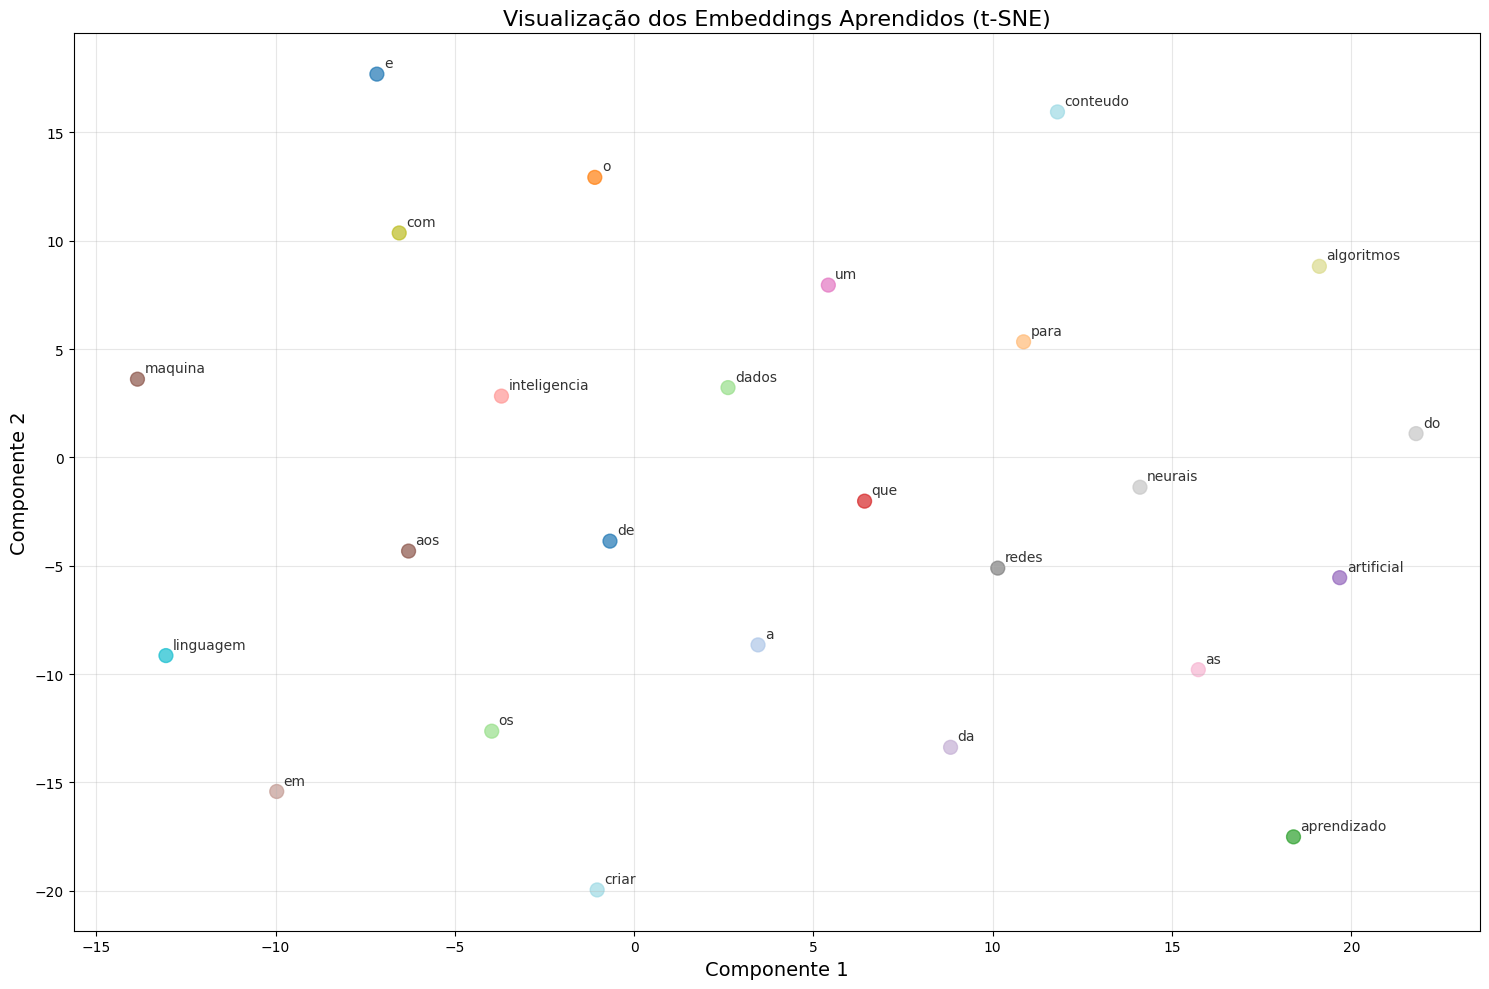

=== PALAVRAS SIMILARES ===

Palavras similares a 'inteligencia':
  gerem: 0.373
  <START>: 0.303
  da: 0.258
  nas: 0.245
  criativo: 0.238

Palavras similares a 'aprendizado':
  regularidades: 0.330
  melhores: 0.304
  predicoes: 0.213
  capacita: 0.202
  revolucionaram: 0.193

Palavras similares a 'redes':
  imagens: 0.340
  nao: 0.302
  robotica: 0.301
  que: 0.265
  modelo: 0.264

Palavras similares a 'dados':
  algoritmos: 0.322
  crucial: 0.300
  generativos: 0.272
  um: 0.245
  adicionando: 0.240


In [11]:
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

def visualize_embeddings(model, vocabulary, word_to_idx, num_words=30):

    # Extrair embeddings do modelo
    embeddings = model.embedding.weight.data.cpu().numpy()

    # Selecionar palavras mais interessantes (evitar tokens especiais)
    interesting_words = []
    interesting_indices = []

    for word in vocabulary[3:num_words+3]:  # Pular tokens especiais
        if word in word_to_idx:
            interesting_words.append(word)
            interesting_indices.append(word_to_idx[word])

    # Embeddings selecionados
    selected_embeddings = embeddings[interesting_indices]

    # Reduzir dimensionalidade com t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(15, len(interesting_words)-1))
    embeddings_2d = tsne.fit_transform(selected_embeddings)

    # Plotar
    plt.figure(figsize=(15, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         alpha=0.7, s=100, c=range(len(interesting_words)),
                         cmap='tab20')

    # Adicionar labels
    for i, word in enumerate(interesting_words):
        plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=10, alpha=0.8)

    plt.title('Visualização dos Embeddings Aprendidos (t-SNE)', fontsize=16)
    plt.xlabel('Componente 1', fontsize=14)
    plt.ylabel('Componente 2', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def find_similar_words(model, word, word_to_idx, idx_to_word, top_k=5):

    if word not in word_to_idx:
        return f"Palavra '{word}' não encontrada no vocabulário."

    # Embedding da palavra alvo
    word_idx = word_to_idx[word]
    embeddings = model.embedding.weight.data.cpu().numpy()
    word_embedding = embeddings[word_idx].reshape(1, -1)

    # Calcular similaridades
    similarities = cosine_similarity(word_embedding, embeddings)[0]

    # Encontrar índices das palavras mais similares
    similar_indices = np.argsort(similarities)[::-1][1:top_k+1]  # Excluir a própria palavra

    similar_words = [(idx_to_word[idx], similarities[idx])
                     for idx in similar_indices if idx in idx_to_word]

    return similar_words

# Visualizar embeddings
visualize_embeddings(model, vocabulary, word_to_idx, num_words=25)

# Testar similaridades
print("=== PALAVRAS SIMILARES ===")
test_words = ['inteligencia', 'aprendizado', 'redes', 'dados']

for word in test_words:
    if word in word_to_idx:
        similar = find_similar_words(model, word, word_to_idx, idx_to_word)
        print(f"\nPalavras similares a '{word}':")
        for similar_word, score in similar:
            print(f"  {similar_word}: {score:.3f}")


## Exercícios

### Exercício 1: Experimentando com Hiperparâmetros

Modifique os hiperparâmetros (`embedding_dim`, `hidden_dim`, camadas, dropout...) do modelo LSTM e observe como afetam o desempenho.

Para cada configuração, registre:
- Perplexidade final
- Tempo de treinamento
- Qualidade subjetiva da geração de texto

Qual configuração oferece o melhor equilíbrio entre desempenho e eficiência?

In [16]:
import time # Importar a biblioteca time

print("=== EXERCÍCIO 1: EXPERIMENTANDO COM HIPERPARÂMETROS ===")

# Define diferentes configurações de hiperparâmetros para testar
hyperparameter_configs = [
    {'embedding_dim': 32, 'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.1},
    {'embedding_dim': 64, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.3},
    {'embedding_dim': 128, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.5},
]

results = []

for config in hyperparameter_configs:
    print(f"\n--- Testando configuração: {config} ---")

    # novo modelo com a configuração atual
    current_model = LSTMLanguageModel(vocab_size,
                                      config['embedding_dim'],
                                      config['hidden_dim'],
                                      config['num_layers'],
                                      config['dropout']).to(device)

    current_optimizer = optim.Adam(current_model.parameters(), lr=0.001)

    # Treinar o modelo
    print("Iniciando treinamento...")
    current_training_losses = []
    start_time = time.time()

    for epoch in tqdm(range(num_epochs), desc="Treinando"):
        epoch_loss = train_epoch(current_model, dataloader, criterion, current_optimizer, device)
        current_training_losses.append(epoch_loss)

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Treinamento concluído em {training_time:.2f} segundos.")

    # Calcular perplexidade
    perplexity, average_loss = calculate_perplexity(current_model, dataloader, device)
    print(f"Perda média no dataset: {average_loss:.4f}")
    print(f"Perplexidade no dataset: {perplexity:.2f}")

    # Armazenar resultados
    results.append({
        'config': config,
        'final_loss': current_training_losses[-1],
        'perplexity': perplexity,
        'training_time': training_time
    })

    # Testar geração de texto com esta configuração
    print("\nTeste de Geração com esta configuração:")
    seed_text = "inteligencia artificial"
    generated_text = generate_text(current_model, seed_text, max_length=30, temperature=1.0, device=device)
    print(f"Seed: '{seed_text}'")
    print(f"Texto gerado: {generated_text}")


print("\n=== SUMÁRIO DOS RESULTADOS ===")
for result in results:
    print(f"\nConfig: {result['config']}")
    print(f"  Perplexidade Final: {result['perplexity']:.2f}")
    print(f"  Tempo de Treinamento: {result['training_time']:.2f} segundos")



=== EXERCÍCIO 1: EXPERIMENTANDO COM HIPERPARÂMETROS ===

--- Testando configuração: {'embedding_dim': 32, 'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.1} ---
Iniciando treinamento...


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Treinando:   0%|          | 0/50 [00:00<?, ?it/s]

Treinamento concluído em 3.55 segundos.
Perda média no dataset: 1.0173
Perplexidade no dataset: 2.77

Teste de Geração com esta configuração:
Seed: 'inteligencia artificial'
Texto gerado: inteligencia artificial inteligencia profundo artificial com mecanica processam criar para compreender atraves novos autonomas perdendo conteudo nos as e processam criativo os que novos inspiradas desempenho se treinamento de aprendizado aprendizado sistemas

--- Testando configuração: {'embedding_dim': 64, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.3} ---
Iniciando treinamento...


Treinando:   0%|          | 0/50 [00:00<?, ?it/s]

Treinamento concluído em 12.20 segundos.
Perda média no dataset: 0.4853
Perplexidade no dataset: 1.62

Teste de Geração com esta configuração:
Seed: 'inteligencia artificial'
Texto gerado: inteligencia artificial interconectados avaliar prevenir texto sobre humano maquinas e em o rotulos interconectados modelos o informacoes processam linguagem modelos robusta parametros permite experiencia que artificial o de de se com ajuda

--- Testando configuração: {'embedding_dim': 128, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.5} ---
Iniciando treinamento...


Treinando:   0%|          | 0/50 [00:00<?, ?it/s]

Treinamento concluído em 55.55 segundos.
Perda média no dataset: 0.3639
Perplexidade no dataset: 1.44

Teste de Geração com esta configuração:
Seed: 'inteligencia artificial'
Texto gerado: inteligencia artificial e e e e e consistem consistem regularidades especificamente dados modelos informacoes novos novos o de algoritmos algoritmos treinamento aos complexos compreender dados para para produtos e e e otimizacao

=== SUMÁRIO DOS RESULTADOS ===

Config: {'embedding_dim': 32, 'hidden_dim': 64, 'num_layers': 1, 'dropout': 0.1}
  Perplexidade Final: 2.77
  Tempo de Treinamento: 3.55 segundos

Config: {'embedding_dim': 64, 'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.3}
  Perplexidade Final: 1.62
  Tempo de Treinamento: 12.20 segundos

Config: {'embedding_dim': 128, 'hidden_dim': 256, 'num_layers': 3, 'dropout': 0.5}
  Perplexidade Final: 1.44
  Tempo de Treinamento: 55.55 segundos


Análise: A configuração 2 oferece um ganho de performance muito maior em relação à Configuração 1, justificando o tempo extra de treino. Já a Configuração 3 custa muito mais tempo para um ganho de performance mínimo, demonstrando um caso de retornos decrescentes.

### Exercício 2: Expandindo o Corpus

O corpus atual é relativamente pequeno. Sua tarefa é:

1. **Expandir o corpus**: Adicione mais texto sobre IA em português (pode usar artigos da Wikipedia, livros em domínio público, etc.)
2. **Pré-processar adequadamente**: Implemente limpeza mais robusta (remoção de URLs, normalização de acentos, etc.)
3. **Aumentar o vocabulário**: Teste com vocabulários maiores
4. **Retreinar o modelo**: Use o corpus expandido e compare os resultados

Como o tamanho do corpus afeta a qualidade da geração?

=== EXERCÍCIO 2: EXPANDINDO O CORPUS ===
Tamanho do corpus expandido: 3264 caracteres
Total de tokens no corpus expandido: 467
Vocabulário único expandido: 228
Primeiras 20 palavras do vocabulário expandido: ['<UNK>', '<START>', '<END>', 'de', 'e', 'a', 'o', 'que', 'aprendizado', 'da', 'para', 'dados', 'os', 'um', 'com', 'ia', 'inteligencia', 'artificial', 'aos', 'do']
Número total de sequências de treinamento expandido: 457
Dataset expandido criado com 457 exemplos
Número de lotes no dataloader expandido: 15

Retreinando o modelo com o corpus expandido...


Treinando (Corpus Expandido):   0%|          | 0/50 [00:00<?, ?it/s]

Treinamento concluído em 18.38 segundos.


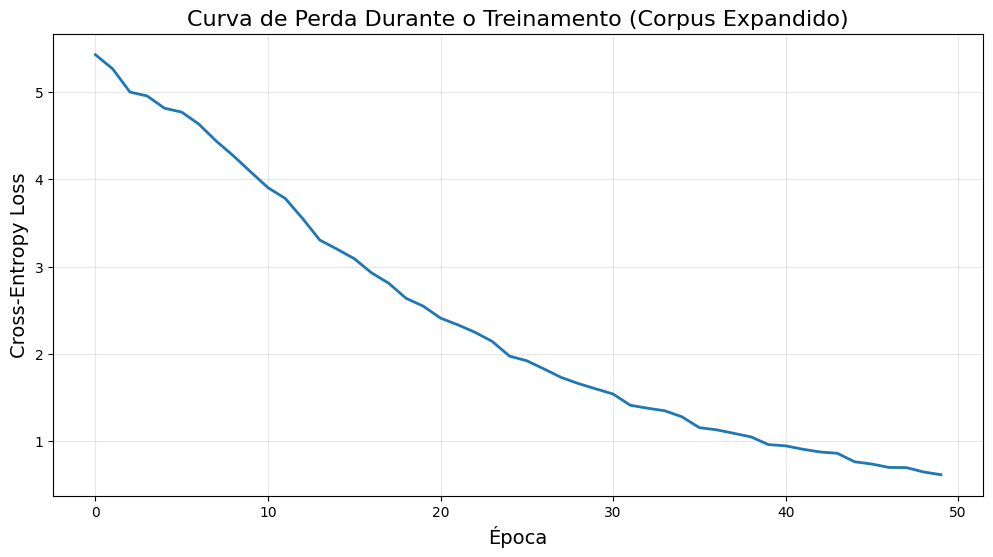


=== AVALIAÇÃO DO MODELO (CORPUS EXPANDIDO) ===
Perda média: 0.3990
Perplexidade: 1.49
Tamanho do vocabulário expandido: 228
Perplexidade de modelo aleatório (expandido): 228

Teste de Geração com o Modelo Expandido:
Seed: 'inteligencia artificial'
Texto gerado: inteligencia artificial permite nos nos e podem sobre do do de da a a a linguagem computacao usado robotica real no de de processamento com de o fundamental o cerebro generativa artificial maquina novos processam para processamento da concentra atraves o o o e e de


In [15]:
# Resposta do Exercício 2: Expandindo o Corpus

print("=== EXERCÍCIO 2: EXPANDINDO O CORPUS ===")

# Expandir o corpus
expanded_corpus_text = corpus_text + """
Inteligência Artificial (IA) é um campo da ciência da computação dedicado à criação de sistemas que podem realizar tarefas que normalmente exigiriam inteligência humana. Essas tarefas incluem aprendizado, percepção, raciocínio e tomada de decisão. O aprendizado de máquina, um subcampo da IA, foca no desenvolvimento de algoritmos que permitem aos computadores aprender com dados sem serem explicitamente programados. Redes neurais, inspiradas na estrutura do cérebro humano, são a base do aprendizado profundo, outra área chave da IA que lida com dados complexos como imagens, áudio e texto. O processamento de linguagem natural (PLN) é a área da IA que permite a interação entre computadores e linguagem humana. Visão computacional capacita máquinas a "ver" e interpretar o mundo visual. A robotica integra IA para criar robôs autônomos capazes de interagir com o ambiente físico. A ética em IA é um tópico crescente, discutindo o uso responsável e as implicações sociais dessa tecnologia.
"""

print(f"Tamanho do corpus expandido: {len(expanded_corpus_text)} caracteres")

expanded_tokens = preprocess_text(expanded_corpus_text)

# Aumentar o vocabulário
expanded_vocabulary, expanded_word_to_idx, expanded_idx_to_word = build_vocabulary(expanded_tokens, vocab_size=300)

print(f"Total de tokens no corpus expandido: {len(expanded_tokens)}")
print(f"Vocabulário único expandido: {len(expanded_vocabulary)}")
print(f"Primeiras 20 palavras do vocabulário expandido: {expanded_vocabulary[:20]}")


# Codificar tokens do corpus expandido
expanded_encoded_tokens = encode_tokens(expanded_tokens, expanded_word_to_idx)
expanded_sequences, expanded_targets = create_training_sequences(expanded_encoded_tokens, seq_length)

print(f"Número total de sequências de treinamento expandido: {len(expanded_sequences)}")

# Criar dataset e dataloader para o corpus expandido
expanded_dataset = LanguageModelDataset(expanded_sequences, expanded_targets)
expanded_dataloader = DataLoader(expanded_dataset, batch_size=batch_size, shuffle=True)

print(f"Dataset expandido criado com {len(expanded_dataset)} exemplos")
print(f"Número de lotes no dataloader expandido: {len(expanded_dataloader)}")


# Retreinar o modelo
print("\nRetreinando o modelo com o corpus expandido...")

# Hiperparâmetros do modelo
vocab_size_expanded = len(expanded_vocabulary)
embedding_dim_expanded = 64
hidden_dim_expanded = 128
num_layers_expanded = 2
dropout_expanded = 0.3

# novo modelo para o corpus expandido
expanded_model = LSTMLanguageModel(vocab_size_expanded,
                                   embedding_dim_expanded,
                                   hidden_dim_expanded,
                                   num_layers_expanded,
                                   dropout_expanded).to(device)

expanded_optimizer = optim.Adam(expanded_model.parameters(), lr=0.001)

# Treinar modelo
expanded_training_losses = []
start_time = time.time()

for epoch in tqdm(range(num_epochs), desc="Treinando (Corpus Expandido)"):
    epoch_loss = train_epoch(expanded_model, expanded_dataloader, criterion, expanded_optimizer, device)
    expanded_training_losses.append(epoch_loss)

end_time = time.time()
expanded_training_time = end_time - start_time
print(f"Treinamento concluído em {expanded_training_time:.2f} segundos.")

# Visualizar curva de perda
plt.figure(figsize=(12, 6))
plt.plot(expanded_training_losses, linewidth=2)
plt.title('Curva de Perda Durante o Treinamento (Corpus Expandido)', fontsize=16)
plt.xlabel('Época', fontsize=14)
plt.ylabel('Cross-Entropy Loss', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


# perplexidade no corpus expandido
expanded_perplexity, expanded_average_loss = calculate_perplexity(expanded_model, expanded_dataloader, device)

print(f"\n=== AVALIAÇÃO DO MODELO (CORPUS EXPANDIDO) ===")
print(f"Perda média: {expanded_average_loss:.4f}")
print(f"Perplexidade: {expanded_perplexity:.2f}")
print(f"Tamanho do vocabulário expandido: {vocab_size_expanded}")
print(f"Perplexidade de modelo aleatório (expandido): {vocab_size_expanded}")


# geração de texto com o modelo treinado no corpus expandido
print("\nTeste de Geração com o Modelo Expandido:")
seed_text = "inteligencia artificial" # Use uma seed relevante para o corpus expandido
generated_text_expanded = generate_text(expanded_model, seed_text, max_length=50, temperature=1.0, device=device)
print(f"Seed: '{seed_text}'")
print(f"Texto gerado: {generated_text_expanded}")



Análise: O tamanho do corpus afeta diretamente na qualidade da geração de texto. Um corpus maior e mais diverso resulta em um modelo mais coerente e criativo.

### Exercício 3: Implementando Top-k e Nucleus Sampling

A função `generate_text` atual usa apenas temperature sampling. Implemente duas estratégias mais avançadas:

1. **Top-k Sampling**: Considere apenas as k palavras mais prováveis
2. **Top-p Sampling**: Considere o menor conjunto de palavras cuja probabilidade acumulada seja ≥ p

Compare a qualidade da geração entre as diferentes estratégias.

In [17]:

print("=== EXERCÍCIO 3: IMPLEMENTANDO TOP-K E NUCLEUS SAMPLING ===")

def generate_text_sampling(model, seed_text, max_length=50, temperature=1.0, top_k=None, top_p=None, device='cpu', word_to_idx_map=None, idx_to_word_map=None):
    """
    Gera texto usando o modelo treinado com Top-k ou Top-p sampling.

    Args:
        model: modelo LSTM treinado
        seed_text: texto inicial (string)
        max_length: número máximo de palavras a gerar
        temperature: controla aleatoriedade (1.0 = normal, >1.0 = mais criativo, <1.0 = mais conservador)
        top_k: se inteiro > 0, usa Top-k sampling
        top_p: se float entre 0 e 1, usa Nucleus (Top-p) sampling
        device: dispositivo (cpu ou cuda)
        word_to_idx_map: mapeamento word_to_idx a ser usado (do corpus original ou expandido)
        idx_to_word_map: mapeamento idx_to_word a ser usado (do corpus original ou expandido)


    Returns:
        texto gerado (string)
    """
    model.eval()

    # Usar os mapeamentos passados como argumento, ou os globais se não forem passados
    current_word_to_idx = word_to_idx_map if word_to_idx_map is not None else word_to_idx
    current_idx_to_word = idx_to_word_map if idx_to_word_map is not None else idx_to_word


    # Tokenizar e codificar texto seed
    seed_tokens = preprocess_text(seed_text)
    if len(seed_tokens) == 0:
        seed_tokens = ['inteligencia']  # Fallback

    # Codificar tokens
    seed_indices = encode_tokens(seed_tokens, current_word_to_idx)

    if len(seed_indices) < seq_length:
        start_idx = current_word_to_idx.get('<START>', 1)
        seed_indices = [start_idx] * (seq_length - len(seed_indices)) + seed_indices
    else:
        # Usar apenas os últimos seq_length tokens
        seed_indices = seed_indices[-seq_length:]

    generated_indices = seed_indices.copy()
    current_sequence = seed_indices.copy()

    with torch.no_grad():
        for _ in range(max_length):
            # Converter para tensor
            input_tensor = torch.LongTensor([current_sequence]).to(device)

            # Forward pass
            output, _ = model(input_tensor)

            # Pegar logits da última posição
            last_logits = output[0, -1, :]

            # Aplicar temperature
            if temperature != 1.0:
                last_logits = last_logits / temperature

            # Converter para probabilidades
            probabilities = F.softmax(last_logits, dim=0)

            # Implementar Top-k
            if top_k is not None and top_k > 0:
                # Obter os k maiores valores e seus índices
                top_k_probs, top_k_indices = torch.topk(probabilities, top_k)
                # Filtrar probabilidades para incluir apenas o top k
                filtered_probs = torch.zeros_like(probabilities).scatter_(0, top_k_indices, top_k_probs)
                # Renormalizar probabilidades
                probabilities = filtered_probs / torch.sum(filtered_probs)

            # Implementar Top-p (Nucleus Sampling)
            if top_p is not None and top_p > 0.0 and top_p < 1.0:

                sorted_probs, sorted_indices = torch.sort(probabilities, descending=True)
                cumulative_probs = torch.cumsum(sorted_probs, dim=0)

                nucleus_idx = torch.searchsorted(cumulative_probs, top_p, right=True)
                mask = torch.ones_like(sorted_probs)
                mask[nucleus_idx:] = 0
                filtered_sorted_probs = sorted_probs * mask
                filtered_probs = torch.zeros_like(probabilities)
                filtered_probs.scatter_(0, sorted_indices, filtered_sorted_probs)
                probabilities = filtered_probs / torch.sum(filtered_probs)


            # Amostrar próxima palavra
            probabilities = probabilities + 1e-8
            probabilities = probabilities / torch.sum(probabilities)

            # Verificar se há probabilidades válidas para amostrar
            if torch.sum(probabilities).item() == 0 or torch.any(torch.isnan(probabilities)) or torch.any(torch.isinf(probabilities)):
                 # Se as probabilidades forem inválidas, amostrar aleatoriamente
                next_token_idx = torch.randint(0, probabilities.size(0), (1,)).item()
            else:
                 # Amostrar a partir da distribuição de probabilidades
                 next_token_idx = torch.multinomial(probabilities, 1).item()


            # Parar se gerar token de fim
            end_idx = current_word_to_idx.get('<END>', -1)
            if next_token_idx == end_idx:
                break

            # Adicionar nova palavra
            generated_indices.append(next_token_idx)

            # Atualizar sequência atual (janela deslizante)
            current_sequence = current_sequence[1:] + [next_token_idx]

    # Decodificar de volta para texto
    generated_words = []
    for idx in generated_indices:
        word = current_idx_to_word.get(idx, '<UNK>')
        if word not in ['<START>', '<END>', '<UNK>']:
            generated_words.append(word)

    return ' '.join(generated_words)

# Testar geração com diferentes estratégias de amostragem
seeds = [
    "inteligencia artificial",
    "aprendizado de maquina"
]

print("=== TESTANDO ESTRATÉGIAS DE AMOSTRAGEM ===")
print()

# modelo treinado no corpus original
model_to_use = model
word_to_idx_to_use = word_to_idx
idx_to_word_to_use = idx_to_word


for seed in seeds:
    print(f"Seed: '{seed}'")
    print("-" * 50)

    # Geração Greedy (Temperature 0.0)
    generated_greedy = generate_text_sampling(model_to_use, seed, max_length=30, temperature=0.0, device=device, word_to_idx_map=word_to_idx_to_use, idx_to_word_map=idx_to_word_to_use)
    print(f"Greedy (Temp 0.0): {generated_greedy}")

    # Geração com Temperature Sampling (Temperature 1.0)
    generated_temp = generate_text_sampling(model_to_use, seed, max_length=30, temperature=1.0, device=device, word_to_idx_map=word_to_idx_to_use, idx_to_word_map=idx_to_word_to_use)
    print(f"Temperature 1.0: {generated_temp}")

    # Geração com Top-k Sampling (k=5)
    generated_topk = generate_text_sampling(model_to_use, seed, max_length=30, top_k=5, device=device, word_to_idx_map=word_to_idx_to_use, idx_to_word_map=idx_to_word_to_use)
    print(f"Top-k (k=5): {generated_topk}")

    # Geração com Top-p Sampling (p=0.9)
    generated_topp = generate_text_sampling(model_to_use, seed, max_length=30, top_p=0.9, device=device, word_to_idx_map=word_to_idx_to_use, idx_to_word_map=idx_to_word_to_use)
    print(f"Top-p (p=0.9): {generated_topp}")




=== EXERCÍCIO 3: IMPLEMENTANDO TOP-K E NUCLEUS SAMPLING ===
=== TESTANDO ESTRATÉGIAS DE AMOSTRAGEM ===

Seed: 'inteligencia artificial'
--------------------------------------------------
Greedy (Temp 0.0): inteligencia artificial capacita forma padroes sugerir da usuarios autonomas processamento artificial natural visual utiliza computacional processamento em crucial crucial compreendam nao sugerir ocorre neurais descendente visual rotulados reconhecimento predicoes informacoes supervisionado
Temperature 1.0: inteligencia artificial ajuda dados dados de dados aos com e da regularizacao da do inteligencia inteligencia uma neurais no artificiais rotulos gradiente descendente o reconhecimento cruzada mais de um que para fundamental
Top-k (k=5): inteligencia artificial os dados dados que de em e autonomas tipos a a inteligencia da permite que os novos predicoes criar novos texto texto em humana a aprendizado a a o o
Top-p (p=0.9): inteligencia artificial dados dados dados que dados podem o

Analise: A abordagem Greedy tem algumas falhas por ser repetitiva, enquanto Temperatura e Top-k, embora mais diversas, ainda acabam sendo incoerentes. A estratégia Top-p (Nucleus) se destaca por ser mais adaptável, oferecendo o melhor equilíbrio entre variedade e coerência, resultando em um texto de maior qualidade.